In [14]:
%pylab inline
matplotlib.rcParams["image.cmap"] = "afmhot"
matplotlib.rcParams["image.interpolation"] = "none"
figsize(10,5)

Populating the interactive namespace from numpy and matplotlib


In [15]:
import clstm
import h5py

# LSTM + CTC Training on UW3 

Let's start by downloading the dataset.

In [16]:
!test -f uw3-dew.h5 || (curl http://www.tmbdev.net/ocrdata-hdf5/uw3-dew.h5.gz > uw3-dew.h5.gz && gunzip uw3-dew.h5.gz)

In HDF5 data files for CLSTM, row `t` represents the input vector at time step `t`. For MNIST, we scan through the original image left-to-right over time.

Transcripts are stored in a separate ragged array of integers; each integer represents a class that can be mapped to a Unicode codepoint using the `codec` array. Class 0 is special and used for skips in the CTC.

Image storage in HDF5 would have to be a rank 3 doubly ragged array, but HDF5 supports only rank 2 arrays. We therefore store image dimensions in a separate array.

[55 73 72 65 84 66 73 72 65  1 38 79 73]


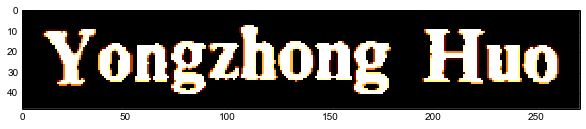

In [17]:
index = 5
h5 = h5py.File("uw3-dew.h5","r")
imshow(h5["images"][index].reshape(*h5["images_dims"][index]).T)
print h5["transcripts"][index]

All input vectors need to have the same length, so we just take that off the first vector in the dataset. The number of outputs can be taken from the codec.

In [18]:
ninput = int(h5["images_dims"][0][1])
noutput = len(h5["codec"])
print ninput,noutput

48 88


Let's create a small bidirectional LSTM network.

In [19]:
net = clstm.make_net("BIDILSTM")
net.set("ninput",ninput)
net.set("nhidden",50)
net.set("noutput",noutput)
net.setLearningRate(1e-3,0.9)
net.initialize()
print clstm.network_info(net)

.bidilstm: 0.001000 0.900000 48 88
.bidilstm.parallel: 0.000100 0.900000 48 100
.bidilstm.parallel.lstm: 0.000100 0.900000 48 50
.bidilstm.parallel.reversed: 0.000100 0.900000 48 50
.bidilstm.parallel.reversed.lstm: 0.000100 0.900000 48 50
.bidilstm.softmax: 0.000100 0.900000 100 88



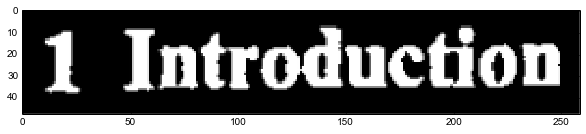

In [20]:
index = 22
xs = array(h5["images"][index].reshape(-1,48,1),'f')
transcript = h5["transcripts"][index]
imshow(xs.reshape(-1,48).T,cmap=cm.gray)

Forward propagation is quite simple: we take the input data and put it into the input sequence of the network, call the `forward` method, and take the result out of the output sequence.

Note that all sequences (including `xs`) in clstm are of rank 3, with indexes giving the time step, the feature dimension, and the batch index, in order.

The output from the network is a vector of posterior probabilities at each time step.

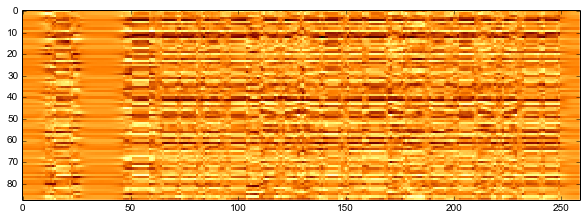

In [21]:
net.inputs.aset(xs)
net.forward()
pred = net.outputs.array()
imshow(pred.reshape(-1,noutput).T, interpolation='none')

Target arrays are similar to the output array but may have a different number of timesteps. They are aligned with the output using CTC.

In [22]:
def mktarget(transcript,noutput):
    N = len(transcript)
    target = zeros((2*N+1,noutput),'f')
    assert 0 not in transcript
    target[0,0] = 1
    for i,c in enumerate(transcript):
        target[2*i+1,c] = 1
        target[2*i+2,0] = 1
    return target

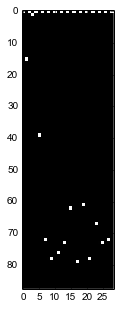

In [23]:
target = mktarget(transcript,noutput)
imshow(target.T)

The CTC alignment now combines the network output with the ground truth.

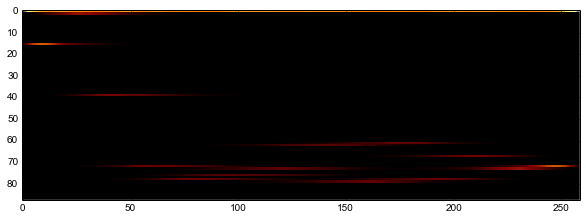

In [24]:
seq = clstm.Sequence()
seq.aset(target.reshape(-1,noutput,1))
aligned = clstm.Sequence()
clstm.seq_ctc_align(aligned,net.outputs,seq)
aligned = aligned.array()
imshow(aligned.reshape(-1,noutput).T, interpolation='none')

Next, we take the aligned output, subtract the actual output, set that as the output deltas, and the propagate the error backwards and update.

In [25]:
deltas = aligned - net.outputs.array()
net.d_outputs.aset(deltas)
net.backward()
net.update()

If we repeat these steps over and over again, we eventually end up with a trained network.

In [26]:
for i in range(2000):
    index = int(rand()*60000)
    xs = array(h5["images"][index].reshape(-1,ninput,1),'f')
    transcript = h5["transcripts"][index]
    s = "".join([chr(codec[cls]) for cls in transcript])
    net.inputs.aset(xs)
    net.forward()
    pred = net.outputs.array()
    target = mktarget(transcript,noutput)
    seq = clstm.Sequence()
    seq.aset(target.reshape(-1,noutput,1))
    aligned = clstm.Sequence()
    clstm.seq_ctc_align(aligned,net.outputs,seq)
    aligned = aligned.array()
    deltas = aligned - net.outputs.array()
    net.d_outputs.aset(deltas)
    net.backward()
    net.update()

NameError: name 'codec' is not defined

In [ ]:
figsize(15,3)
imshow(xs.reshape(-1,ninput).T)

In [ ]:
def log10max(a,eps=1e-3):
    return log10(maximum(a,eps))

In [ ]:
figsize(10,10)
subplot(211); imshow(xs.reshape(-1,ninput)[:200].T)
subplot(212); imshow(pred.reshape(-1,noutput)[:200].T)

In [ ]:
imshow(log10max(pred.reshape(-1,noutput)[:200].T))

In [ ]:
imshow(aligned.reshape(-1,noutput)[:200].T)

In [ ]:
imshow(log10max(aligned.reshape(-1,noutput)[:200].T))